In [1]:
import ssgetpy
import os
import pandas as pd
import numpy as np
from scipy.io import mmread
from nlass import NLASS 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 1. SETUP: Define where to save
download_folder = 'matrices_collection'
registry_file = 'matrix_registry.csv'

os.makedirs(download_folder, exist_ok=True)

# (SPD, Real, 1k-50k rows)
print("Searching SuiteSparse collection...")
results = ssgetpy.search(
    rowbounds=(1000, 50000), 
    isspd=True, # SPD + real
    limit=10,  # Change to None to download ALL (approx 200 matrices)
    kind='Structural Problem' # PHYSUCS RULEES
)

print(f"Found {len(results)} matrices.")

Searching SuiteSparse collection...
Found 10 matrices.


In [3]:
# 3. DOWNLOAD 
# WARNING!!! DO NOT PRESS RADNOMNLY : yes , I see you Kirill
print(f"Downloading to '{download_folder}'... (This may take time)")
results.download(destpath=download_folder, extract=True)
print("Download complete.")

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

Download complete.


In [ ]:
# 4. INDEXING
print("Generating registry CSV...")
data = []

for matrix in results:
    
    mtx_path = os.path.join(download_folder, matrix.name, f"{matrix.name}.mtx")
    
    data.append({
        'name': matrix.name,
        'group': matrix.group,
        'rows': matrix.rows,
        'cols': matrix.cols,
        'nnz': matrix.nnz,
        'cond_est': 'Unknown', # Placeholder for later benchmarking
        'path': mtx_path
    })

df = pd.read_csv(registry_file) if os.path.exists(registry_file) else pd.DataFrame(data)
# Create registryssssss
if not os.path.exists(registry_file):
    df = pd.DataFrame(data)
    df.to_csv(registry_file, index=False)
    print(f"Created new registry: {registry_file}")
else:
    pd.DataFrame(data).to_csv(registry_file, index=False)
    print(f"Updated registry: {registry_file}")


print("\nPreview of dataset:")
print(df[['name', 'rows', 'nnz', 'status']].head())

Generating registry CSV...
Updated registry: matrix_registry.csv

Preview of dataset:
       name  rows    nnz   status
0  bcsstk08  1074  12960  Unknown
1  bcsstk09  1083  18437  Unknown
2  bcsstk10  1086  22070  Unknown
3  bcsstk11  1473  34241  Unknown
4  bcsstk12  1473  34241  Unknown


In [ ]:
df = pd.read_csv('matrix_registry.csv')
results = []

print(f"Starting benchmarks for {len(df)} matrices...")

for index, row in df.iterrows():
    print(f"[{index+1}/{len(df)}] Processing {row['name']}...", end=" ")
    
    try:
        A = mmread(row['path'])
        solver = NLASS(A)
        
       
        row_result = {}
        
        # A. CG None
        row_result.update(solver.test_cg_none())
        
        # B. Jacobi
        row_result.update(solver.test_cg_jacobi())
        
        # C. ILU
        row_result.update(solver.test_cg_ilu())
        
        # D. Exact
        row_result.update(solver.test_exact())
        
        print("Done.")
        results.append(row_result)
        
    except Exception as e:
        print(f"Failed: {e}")
        results.append({})


df_results = pd.DataFrame(results)
df_final = pd.concat([df, df_results], axis=1)
df_final.to_csv('matrix_benchmarks.csv', index=False)
print("\nBenchmarks Complete! Saved to 'matrix_benchmarks.csv'")
display(df_final.head())

Starting benchmarks for 10 matrices...
[1/10] Processing bcsstk08... 

/kaggle/working/nlass.py:73: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(self.A, drop_tol=1e-4, fill_factor=20)
/kaggle/working/nlass.py:88: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(self.A)


Done.
[2/10] Processing bcsstk09... Done.
[3/10] Processing bcsstk10... Done.
[4/10] Processing bcsstk11... Done.
[5/10] Processing bcsstk12... Done.
[6/10] Processing bcsstk14... Done.
[7/10] Processing bcsstk15... Done.
[8/10] Processing bcsstk16... Done.
[9/10] Processing bcsstk17... Done.
[10/10] Processing bcsstk18... Done.

Benchmarks Complete! Saved to 'matrix_benchmarks.csv'


,name,group,rows,cols,nnz,cond_est,path,status,CG_Time,CG_Iter,CG_Res,Jacobi_Time,Jacobi_Iter,Jacobi_Res,ILU_Time,ILU_Iter,ILU_Res,Exact_Time,Exact_Iter,Exact_Res
0,bcsstk08,HB,1074,1074,12960,Unknown,matrices_collection/bcsstk08/bcsstk08.mtx,Unknown,0.079008,1259,8.680639e-07,0.007088,98,6.065983e-07,1.759737,5000,4.979180e-04,0.038137,1,7.364747e-16
1,bcsstk09,HB,1083,1083,18437,Unknown,matrices_collection/bcsstk09/bcsstk09.mtx,Unknown,0.010179,177,9.774463e-07,0.009059,158,8.488272e-07,0.001408,3,2.261143e-07,0.009142,1,7.625722e-16
2,bcsstk10,HB,1086,1086,22070,Unknown,matrices_collection/bcsstk10/bcsstk10.mtx,Unknown,0.100682,1692,9.867403e-07,0.022671,284,9.825157e-07,0.000921,2,3.041378e-08,0.003572,1,5.064045e-16
3,bcsstk11,HB,1473,1473,34241,Unknown,matrices_collection/bcsstk11/bcsstk11.mtx,Unknown,0.137620,1638,9.573944e-07,0.039279,450,9.612263e-07,2.590480,5000,1.613534e-06,0.011762,1,3.485423e-16
4,bcsstk12,HB,1473,1473,34241,Unknown,matrices_collection/bcsstk12/bcsstk12.mtx,Unknown,0.127537,1638,9.573944e-07,0.036973,450,9.612263e-07,2.560997,5000,1.613534e-06,0.012000,1,3.485423e-16


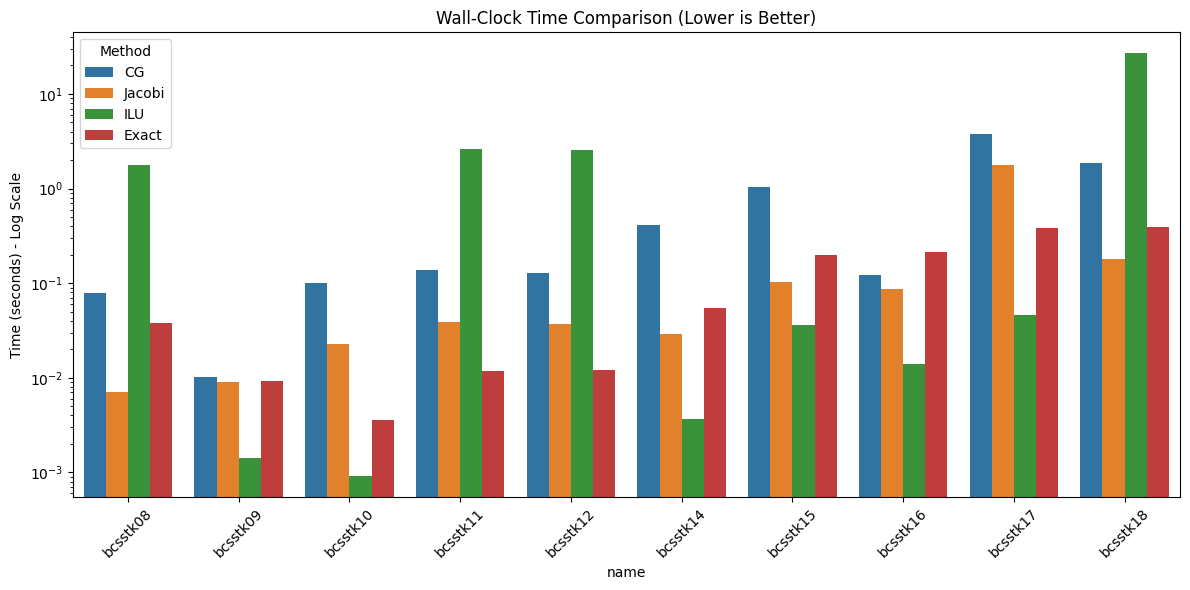

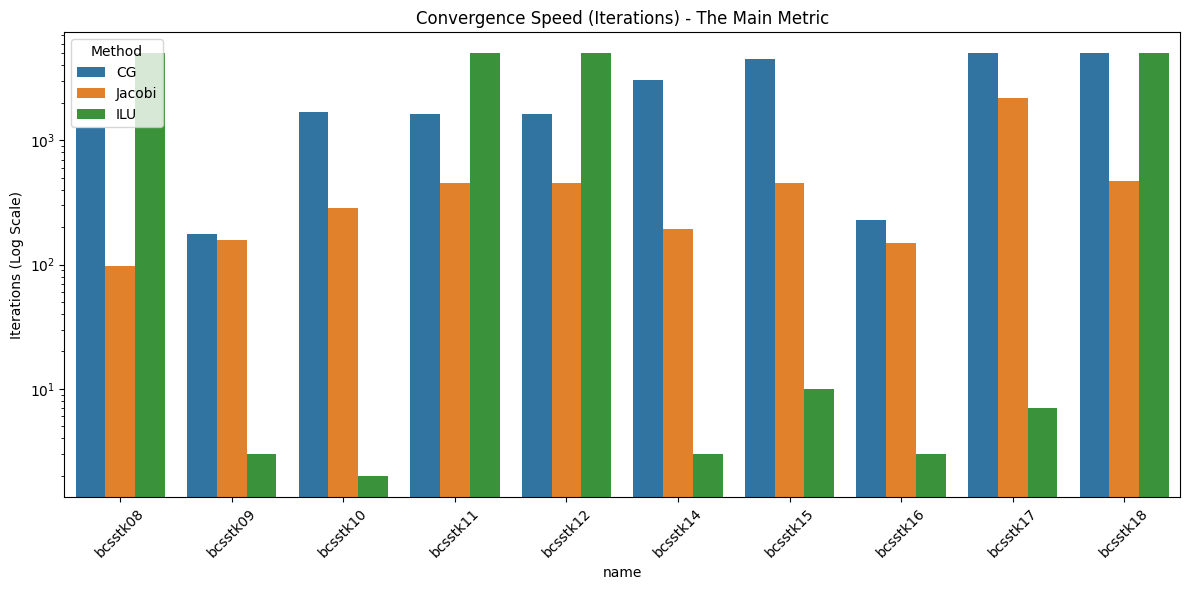

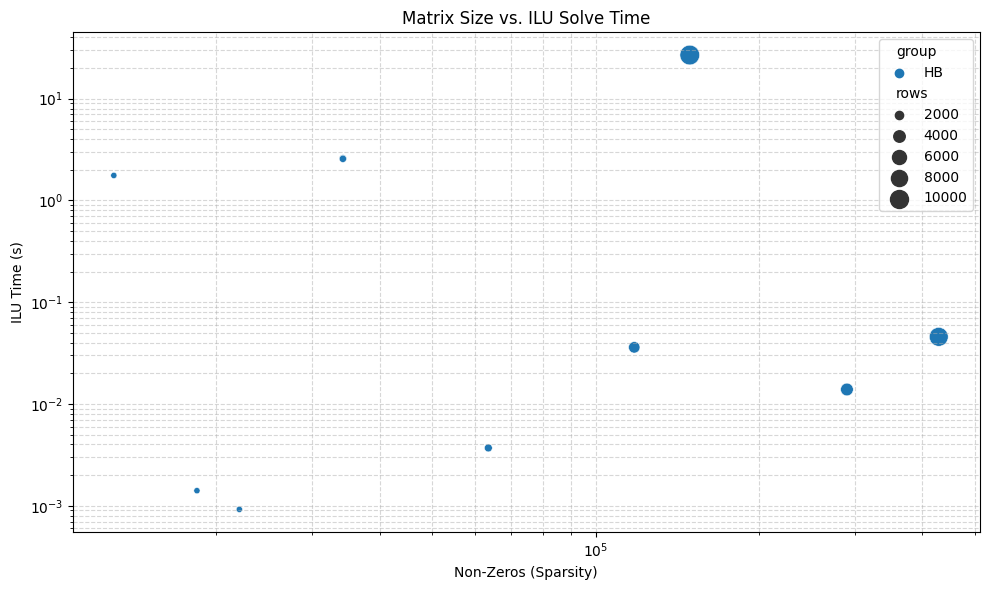

In [ ]:
df = pd.read_csv('matrix_benchmarks.csv')


os.makedirs('figures', exist_ok=True)
methods = ['CG', 'Jacobi', 'ILU', 'Exact']


plt.figure(figsize=(12, 6))
time_cols = [f"{m}_Time" for m in methods]
df_time = df.melt(id_vars=['name'], value_vars=time_cols, var_name='Method', value_name='Time (s)')
df_time['Method'] = df_time['Method'].str.replace('_Time', '')

sns.barplot(data=df_time, x='name', y='Time (s)', hue='Method')
plt.yscale('log') 
plt.xticks(rotation=45)
plt.title("Wall-Clock Time Comparison (Lower is Better)")
plt.ylabel("Time (seconds) - Log Scale")
plt.tight_layout()
plt.savefig('figures/benchmark_time.png')
plt.show()


plt.figure(figsize=(12, 6))
iter_cols = [f"{m}_Iter" for m in ['CG', 'Jacobi', 'ILU']] # Exact has 1 iter, boring to plot
df_iter = df.melt(id_vars=['name'], value_vars=iter_cols, var_name='Method', value_name='Iterations')
df_iter['Method'] = df_iter['Method'].str.replace('_Iter', '')

sns.barplot(data=df_iter, x='name', y='Iterations', hue='Method')
plt.yscale('log')
plt.xticks(rotation=45)
plt.title("Convergence Speed (Iterations) - The Main Metric")
plt.ylabel("Iterations (Log Scale)")
plt.tight_layout()
plt.savefig('figures/benchmark_iters.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='nnz', y='ILU_Time', size='rows', sizes=(20, 200), hue='group')
plt.title("Matrix Size vs. ILU Solve Time")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Non-Zeros (Sparsity)")
plt.ylabel("ILU Time (s)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig('figures/benchmark_scatter.png')
plt.show()